# 0. Imports

In [2]:
# for data handling and manipulation:
import pandas as pd
import numpy as np

# for os handling
import os

# for pre-processing
from sklearn.preprocessing import StandardScaler

# import the classifiers to fit:
from sklearn.svm import LinearSVC

# import metrics
from sklearn.metrics import fbeta_score, classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay, make_scorer

# for tabulating results
from tabulate import tabulate

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# for handling warnings
import warnings

# for hyper-parameter tuning
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import GridSearchCV

In [3]:
# Reading the train, test and validation data into this notebook 

X_train_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_train_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_train_gray = X_train_gray.to_numpy()

y_train = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_train.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_train = y_train.to_numpy(dtype = 'int64').flatten()

X_val_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_val_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_val_gray = X_val_gray.to_numpy()

y_val = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_val.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_val = y_val.to_numpy(dtype = 'int64').flatten()

X_test_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_test_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_test_gray = X_test_gray.to_numpy()

y_test = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_test.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_test = y_test.to_numpy(dtype = 'int64').flatten()

In [4]:
X_train_gray.shape, y_train.shape, X_val_gray.shape, y_val.shape, X_test_gray.shape, y_test.shape

((791, 98), (791,), (98, 98), (98,), (100, 98), (100,))

In [5]:
X_final_train_gray = np.concatenate((X_train_gray, X_val_gray), axis = 0)
y_train_final = np.concatenate((y_train, y_val), axis = 0)

## Function to calculate metrics

In [6]:
def calculate_metrics(y_pred, y_true, normalize = False):
    
    with warnings.catch_warnings():
        
        warnings.filterwarnings('ignore')
        # calculate accuracy:
        temp = round(accuracy_score(y_true, y_pred),2)
        print('Accuracy in detecting Accident class: {}'.format(temp))
        print('\n------------------------------------------------------------------------------------------\n')
        
        my_data = []
        cr = classification_report(y_true, y_pred, output_dict = True)

        # calculate precision:
        my_data.append(['Precision',round(cr['0']['precision'],2), round(cr['1']['precision'],2)])

        # calculate recall:
        my_data.append(['Recall',round(cr['0']['recall'],2), round(cr['1']['recall'],2)])

        # f1-score:
        my_data.append(['f1-score',round(cr['0']['f1-score'],2), round(cr['1']['f1-score'],2)])

        head = ['Metric','Non-Accident images','Accident images']

        print(tabulate(my_data, headers = head, tablefmt = 'grid'))
        print('\n------------------------------------------------------------------------------------------\n')

        # calculate sensitivity (recall of positive class for binary classification)
        temp = round(cr['1']['recall'],2)
        print('Sensitivity/ ability to correctly classifiy to Accident class is: {}'.format(temp))
    
        # calculate specificity (recall of negative class for binary classification)
        temp = round(cr['0']['recall'],2)
        print('Specificity/ ability to correctly classifiy to Non-Accident class is: {}'.format(temp))
        print('\n------------------------------------------------------------------------------------------\n')

        # calculate f1-beta score:
        print('Fbeta score with beta = 1.5 is: {}'.format(round(fbeta_score(y_true, y_pred,beta = 1.4),2)))
        print('\n------------------------------------------------------------------------------------------\n')

        # Confusion matrix:

        if normalize == False:
            cm = confusion_matrix(y_true, y_pred)
            disp = ConfusionMatrixDisplay(cm, display_labels = ["Non-Accident", 'Accident'])
            disp.plot()
            plt.title('Confusion Matrix')
            plt.show()
            print('\n------------------------------------------------------------------------------------------\n')

        else:
            cm = confusion_matrix(y_true, y_pred, normalize='all')
            disp = ConfusionMatrixDisplay(cm, display_labels = ["Non-Accident", 'Accident'])
            disp.plot()
            plt.title('Confusion Matrix')
            plt.show()
            print('\n------------------------------------------------------------------------------------------\n')


        # ROC curve:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, marker = 'o')
        plt.xlabel('% of Non-Accidents incorrectly classified')
        plt.ylabel('% of Accidents correctly classified')
        plt.title('ROC Curve')
        plt.show()
        print('\n------------------------------------------------------------------------------------------\n')
        temp = round(auc(fpr, tpr),2)
        print('AUC score is: {}'.format(temp))

    return 

# Fitting a Linear SVM

## On grayscale images

## Scale the data

In [7]:
scaler = StandardScaler()
X_train_gray_sc = scaler.fit_transform(X_final_train_gray)
X_test_gray_sc = scaler.transform(X_test_gray)

In [8]:
X_train_gray_sc.shape, X_test_gray_sc.shape

((889, 98), (100, 98))

### Let's formally do hyper-parameter tuning, using Bayes Optimization and Grid Search. The default parameters are also an option to use for both Bayes and Grid search CV, if they indeed have the best generalizing capability, then it will get detected.

In [8]:
# parameters1 use `squared hinge loss`, parameters2 use `hinge` loss (as hinge loss is not supported with 'l1' penalty)

parameters1 = {'penalty': ['l1','l2'], 'tol' : Real(1e-6, 1, prior = 'uniform'), 'C': Real(0.00001,5,'uniform'), 'fit_intercept' : [True, False],
               'intercept_scaling': Real(0.001,10,'uniform')}   

parameters2 = {'penalty': ['l2'], 'loss': ['hinge'],'tol' : Real(1e-6, 1, prior = 'uniform'), 'C': Real(0.00001,5,'uniform'), 'fit_intercept' : [True, False],
               'intercept_scaling': Real(0.001,10,'uniform')} 

fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)                                                                     

In [9]:
opt_1 = BayesSearchCV(LinearSVC(random_state = 5000, class_weight= {0:1, 1:1.5}, dual='auto', max_iter=2000), parameters1, n_iter = 200, scoring = fbeta_scorer, verbose = 5,
                       random_state = 5000, cv = 3)

np.int = int  # numpy doesn't have int attribute now, to avoid an error in existing code, need to use int in place of this.

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt_1.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=4.260980139567624, fit_intercept=False, intercept_scaling=9.723023608492612, penalty=l1, tol=0.5239903164250959;, score=0.757 total time=   0.0s
[CV 2/3] END C=4.260980139567624, fit_intercept=False, intercept_scaling=9.723023608492612, penalty=l1, tol=0.5239903164250959;, score=0.754 total time=   0.0s
[CV 3/3] END C=4.260980139567624, fit_intercept=False, intercept_scaling=9.723023608492612, penalty=l1, tol=0.5239903164250959;, score=0.743 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=3.079517797310609, fit_intercept=True, intercept_scaling=5.636724506655338, penalty=l1, tol=0.8971472455515893;, score=0.786 total time=   0.0s
[CV 2/3] END C=3.079517797310609, fit_intercept=True, intercept_scaling=5.636724506655338, penalty=l1, tol=0.8971472455515893;, score=0.763 total time=   0.0s
[CV 3/3] END C=3.079517797310609, fit_intercept=True, intercept_scaling=5.6367245066

[CV 2/3] END C=2.4303973980005473, fit_intercept=False, intercept_scaling=8.496478869038734, penalty=l1, tol=0.07568312306173194;, score=0.823 total time=   0.0s
[CV 3/3] END C=2.4303973980005473, fit_intercept=False, intercept_scaling=8.496478869038734, penalty=l1, tol=0.07568312306173194;, score=0.743 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=1.8250189608437943, fit_intercept=False, intercept_scaling=4.543135099590207, penalty=l1, tol=0.10998150355715693;, score=0.755 total time=   0.0s
[CV 2/3] END C=1.8250189608437943, fit_intercept=False, intercept_scaling=4.543135099590207, penalty=l1, tol=0.10998150355715693;, score=0.799 total time=   0.0s
[CV 3/3] END C=1.8250189608437943, fit_intercept=False, intercept_scaling=4.543135099590207, penalty=l1, tol=0.10998150355715693;, score=0.749 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=1.3955768075505535, fit_intercept=False, intercept_scalin

In [10]:
opt_2 = BayesSearchCV(LinearSVC(random_state = 5000, class_weight= {0:1, 1:1.5}, dual='auto', max_iter=2000), parameters2, n_iter = 200, scoring = fbeta_scorer, verbose = 5, random_state = 5000, cv = 3)

np.int = int  # numpy doesn't have int attribute now, to avoid an error in existing code, need to use int in place of this.

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt_2.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=4.260980139567624, fit_intercept=False, intercept_scaling=9.723023608492612, loss=hinge, penalty=l2, tol=0.341589826933691;, score=0.755 total time=   0.1s
[CV 2/3] END C=4.260980139567624, fit_intercept=False, intercept_scaling=9.723023608492612, loss=hinge, penalty=l2, tol=0.341589826933691;, score=0.814 total time=   0.0s
[CV 3/3] END C=4.260980139567624, fit_intercept=False, intercept_scaling=9.723023608492612, loss=hinge, penalty=l2, tol=0.341589826933691;, score=0.765 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=3.079517797310609, fit_intercept=True, intercept_scaling=5.636724506655338, loss=hinge, penalty=l2, tol=0.7791052389274001;, score=0.755 total time=   0.0s
[CV 2/3] END C=3.079517797310609, fit_intercept=True, intercept_scaling=5.636724506655338, loss=hinge, penalty=l2, tol=0.7791052389274001;, score=0.828 total time=   0.0s
[CV 3/3] END C=3.0795177973

In [27]:
print('Best score on a fold of train data with squared hinge loss:', round(opt_1.best_score_,6))

Best score on a fold of train data with squared hinge loss: 0.797131


In [15]:
print('Best parameters with squared hinge loss using 3-fold cross validation:', opt_1.best_params_)

Best parameters with squared hinge loss using 3-fold cross validation: OrderedDict([('C', 4.2899527999680585), ('fit_intercept', True), ('intercept_scaling', 9.689161327612949), ('penalty', 'l2'), ('tol', 1e-06)])


In [28]:
print('Best score on a fold of train data with squared hinge loss:', round(opt_2.best_score_,6))

Best score on a fold of train data with squared hinge loss: 0.799956


In [17]:
print('Best parameters with hinge loss using 3-fold cross validation:', opt_2.best_params_)

Best parameters with hinge loss using 3-fold cross validation: OrderedDict([('C', 2.740867157543261), ('fit_intercept', True), ('intercept_scaling', 10.0), ('loss', 'hinge'), ('penalty', 'l2'), ('tol', 1e-06)])


## Trying Grid Search now

In [18]:
# parameters1 use `squared hinge loss`, parameters2 use `hinge` loss (as hinge loss is not supported with 'l1' penalty)

parameters1 = {'penalty': ['l1','l2'], 'tol' : [1e-6, 1e-4, 1e-2, 1e-1, 5e-1, 8e-1, 1], 'C': [0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5],
               'fit_intercept' : [True, False], 'intercept_scaling': [0.001, 0.01, 0.1, 1, 3, 6, 8,10]}   

parameters2 = {'penalty': ['l2'], 'loss': ['hinge'],'tol' : [1e-6, 1e-4, 1e-2, 1e-1, 5e-1, 8e-1, 1], 'C': [0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5],
               'fit_intercept' : [True, False], 'intercept_scaling': [0.001, 0.01, 0.1, 1, 3, 6, 8,10]} 

fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)                                                                     

In [19]:
opt_gs_1 = GridSearchCV(LinearSVC(random_state = 5000, class_weight= {0:1, 1:1.5}, dual='auto', max_iter=3000), parameters1,
                        scoring = fbeta_scorer, verbose = 5, cv = 3)


opt_gs_1.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 2240 candidates, totalling 6720 fits
[CV 1/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.000 total time=   0.0s
[CV 2/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.000 total time=   0.0s
[CV 3/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.000 total time=   0.0s
[CV 1/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.000 total time=   0.0s
[CV 2/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.000 total time=   0.0s
[CV 3/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.000 total time=   0.0s
[CV 1/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.000 total time=   0.0s
[CV 2/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, penalty=l1, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.773 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.803 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.773 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.803 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.777 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.760 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.764 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.773 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.803 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.773 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.803 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.777 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.767 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.760 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.774 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.01, pena

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.820 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.780 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.820 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.777 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.769 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.820 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.760 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.764 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.1, penalty=l1, t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.826 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.770 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.780 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.826 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.777 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.822 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.755 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.8

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.826 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.767 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.769 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.826 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.777 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.824 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.762 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.8

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.826 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.772 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.769 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.826 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.777 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.824 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.757 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.8

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.826 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.767 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.769 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.826 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.777 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.824 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.757 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.8

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.769 total time=   0.3s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.826 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.769 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.826 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.777 total time=   0.4s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.824 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.760 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.757 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.773 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.803 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.773 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.803 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.777 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.762 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.773 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.803 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.773 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.803 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.762 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.773 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.803 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.773 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.803 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.777 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.762 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.1, pena

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.773 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.803 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.775 total time=   0.4s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.773 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.803 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.777 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.762 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.773 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.803 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.773 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.803 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.762 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.773 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.803 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.773 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.803 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.777 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.762 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.773 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.803 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.773 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.803 total time=   0.2s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.777 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.762 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.773 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.803 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.773 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.803 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.762 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=10, penalty=l1, t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.796 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.788 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.801 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.787 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.773 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.804 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.001, pen

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.806 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.792 total time=   0.5s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.796 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.782 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.778 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.749 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.5;, score=0.790 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.01, penalty=l1, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.822 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.787 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.775 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.825 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.787 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.826 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.773 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.5;, score=0.779 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.5;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.766 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.822 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.772 total time=   0.4s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.773 total time=   0.2s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.822 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.782 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.820 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.785 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.779 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.768 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.827 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.785 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.773 total time=   0.2s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.822 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.787 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.822 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.777 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.768 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.827 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.773 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.773 total time=   0.4s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.822 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.787 total time=   0.6s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.822 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.799 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.768 total time=   0.8s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.827 total time=   0.7s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.773 total time=   0.7s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.773 total time=   0.6s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.817 total time=   0.8s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.787 total time=   0.8s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.822 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.799 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.768 total time=   0.8s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.827 total time=   0.6s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.773 total time=   0.3s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.822 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.822 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.799 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.806 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.788 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.799 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.787 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.749 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.780 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.806 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.788 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.799 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.787 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.749 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.01, pen

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.806 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.788 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.799 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.787 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.749 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.1, penalty=l1, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.806 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.788 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.799 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.787 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.749 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.806 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.788 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.799 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.787 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.749 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.806 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.788 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.799 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.787 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.749 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.806 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.788 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.775 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.799 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.787 total time=   0.4s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.749 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.806 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.788 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.799 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.787 total time=   0.4s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.749 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.5;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.769 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.788 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.800 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.788 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.808 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.773 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.804 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.5;, score=0.786 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.001, pen

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.796 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.808 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.769 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.804 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.749 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.5;, score=0.790 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.01, penalty=l1, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.813 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.773 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.769 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.815 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.790 total time=   0.4s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.820 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.777 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.749 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.5;, score=0.779 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.5;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.778 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.820 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.764 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.810 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.788 total time=   0.5s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.766 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.820 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.785 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.795 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.778 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.814 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.772 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.764 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.810 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.788 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.766 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.820 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.795 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.768 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.817 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.772 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.764 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.810 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.788 total time=   0.4s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.820 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.799 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.768 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.813 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.764 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.810 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.793 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.820 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.799 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.778 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.813 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.772 total time=   0.4s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.764 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.810 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.820 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.775 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.799 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.787 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.787 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.01, pen

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.787 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.777 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.1, penalty=l1, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.787 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.787 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.790 total time=   0.4s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.787 total time=   0.4s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.777 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.798 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.787 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.790 total time=   0.4s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.787 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.5;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.801 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.782 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.793 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.797 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.769 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.804 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.769 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.804 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.5;, score=0.786 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.001, pen

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.775 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.803 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.788 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.777 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.793 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.795 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.799 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.810 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.5;, score=0.788 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.01, penalty=l1, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.820 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.788 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.759 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.815 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.795 total time=   0.4s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.822 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.785 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.755 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.749 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.5;, score=0.779 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.5;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.769 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.817 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.775 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.764 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.812 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.822 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.795 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.769 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.821 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.769 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.812 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.766 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.824 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.768 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.795 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.773 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.822 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.769 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.810 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.766 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.822 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.761 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.799 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.764 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.822 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.769 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.810 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.795 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.822 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.761 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.799 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.764 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.822 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.769 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.808 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.795 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.822 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.778 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.792 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.801 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.790 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.793 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.792 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.801 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.790 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.793 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.792 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.01, pen

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.801 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.790 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.793 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.792 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.1, penalty=l1, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.801 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.790 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.793 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.792 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.801 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.790 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.793 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.792 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.801 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.790 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.793 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.792 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.801 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.790 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.793 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.792 total time=   0.4s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.801 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.790 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.793 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.792 total time=   0.4s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.5;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.778 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.794 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.788 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.787 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.795 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.769 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.804 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.785 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.769 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.804 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.001, penalty=l1, tol=0.5;, score=0.786 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.001, pen

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.777 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.804 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.788 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.777 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.786 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.795 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.769 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.799 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.783 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.807 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, tol=0.5;, score=0.786 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.01, penalty=l1, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.775 total time=   0.7s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.815 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.785 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.762 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.817 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.802 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.825 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.778 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.795 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.1, penalty=l1, tol=0.5;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.769 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.817 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.768 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.810 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.799 total time=   0.4s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.822 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.755 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.795 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.764 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.810 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.768 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.815 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.804 total time=   0.4s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.822 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.795 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.764 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.807 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.775 total time=   0.4s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.768 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.812 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.795 total time=   0.4s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.824 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.773 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.761 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.799 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.764 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.807 total time=   0.6s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.780 total time=   0.6s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.768 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.812 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.790 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.824 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.770 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.761 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.799 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.749 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.764 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.807 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.768 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.819 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.788 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.824 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.768 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.761 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.792 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.754 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.5;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=10, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.798 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.777 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.0001;, score=0.804 total time=   0.4s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.769 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.001, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.780 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.0001;, score=0.804 total time=   0.4s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.769 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.01, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.01, pen

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.775 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.798 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=1e-06;, score=0.780 total time=   0.4s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.0001;, score=0.804 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.769 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.1, penalty=l1, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.775 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.798 total time=   0.7s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=1e-06;, score=0.780 total time=   0.8s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.777 total time=   0.8s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.780 total time=   0.9s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.0001;, score=0.804 total time=   1.8s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.769 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.01;, score=0.780 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=1, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.775 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.0001;, score=0.804 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.769 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=3, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=1e-06;, score=0.780 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.0001;, score=0.804 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.769 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=6, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.798 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=1e-06;, score=0.780 total time=   0.4s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.777 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.780 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.0001;, score=0.804 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.769 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=8, penalty=l1, tol=0.5;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.775 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.798 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=1e-06;, score=0.780 total time=   0.7s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.777 total time=   0.8s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.780 total time=   0.6s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.0001;, score=0.804 total time=   0.7s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.769 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.801 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.777 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.1;, score=0.744 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=10, penalty=l1, tol=0.5;,

GridSearchCV(cv=3,
             estimator=LinearSVC(class_weight={0: 1, 1: 1.5}, dual='auto',
                                 max_iter=3000, random_state=5000),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5],
                         'fit_intercept': [True, False],
                         'intercept_scaling': [0.001, 0.01, 0.1, 1, 3, 6, 8,
                                               10],
                         'penalty': ['l1', 'l2'],
                         'tol': [1e-06, 0.0001, 0.01, 0.1, 0.5, 0.8, 1]},
             scoring=make_scorer(fbeta_score, beta=1.4), verbose=5)

In [20]:
opt_gs_2 = GridSearchCV(LinearSVC(random_state = 5000, class_weight= {0:1, 1:1.5}, dual='auto', max_iter=3000), parameters2,
                        scoring = fbeta_scorer, verbose = 5, cv = 3)


opt_gs_2.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 1120 candidates, totalling 3360 fits
[CV 1/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.752 total time=   0.0s
[CV 2/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.769 total time=   0.0s
[CV 3/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.703 total time=   0.0s
[CV 1/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.752 total time=   0.0s
[CV 2/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.769 total time=   0.0s
[CV 3/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.703 total time=   0.0s
[CV 1/3] END C=1e-05, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.752 total time=   

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.001, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.001, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.748 total time=   0.0s
[CV 3/3] END C=0.001, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.750 total time=   0.0s
[CV 1/3] END C=0.001, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.768 total time=   0.0s
[CV 2/3] END C=0.001, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.748 total time=   0.0s
[CV 3/3] END C=0.001, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.750 total time=   0.0s
[CV 1/3] END C=0.001, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.768 total time=   0.0s
[CV 2/3] END C=0.001, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, scor

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.01, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.01, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.01, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.01, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, p

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.795 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.797 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.774 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.797 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.771 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.802 total time=   0.1s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.802 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.729 total time=   0.1s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.768 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.729 to

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.771 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.724 total time=   0.1s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.771 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.724 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.802 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.724 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.724 total time=   0.1s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.768 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.802 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.724 total time=   0.1s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.797 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.724 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.768 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.7

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.001, loss=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, p

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penal

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.807 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.727 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1;, score=0.807 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1;, sco

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.774 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.8

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.774 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.732 total time=   0.1s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.774 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.731 total time=   0.1s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.8

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.774 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.807 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.727 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1;, score=0.807 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.807 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.727 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1;, score=0.807 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.774 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.774 total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.797 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.778 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.741 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.778 total time=   0.1s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.741 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.813 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.778 total time=   0.1s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.754 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.798 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.741 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.797 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.781 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.741 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.781 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.764 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.811 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.781 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.750 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.798 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.748 to

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblin

[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.801 total time=   0.1s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.737 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.803 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.801 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.737 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.801 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.761 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.746 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.808 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.803 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.787 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.775 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.803 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.787 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.775 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.804 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.784 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.771 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.802 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.792 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.754 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.804 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.739 total time=   0.0s
[CV 2/3

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.762 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.804 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.789 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.762 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.804 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.789 total time=   0.1s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.762 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.811 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.789 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.775 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.811 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.786 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.804 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.782 total time=   0.0s
[CV 1/

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.809 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.794 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.777 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.794 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.777 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.809 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.788 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.775 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.811 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.792 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.816 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.787 total time=   0.0s
[CV 1/

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.809 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.789 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.777 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.789 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.777 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.809 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.789 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.775 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.811 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.792 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.754 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.809 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.787 total time=   0.0s
[CV 1/

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.752 total time=   0.2s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.804 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.791 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.752 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.804 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.791 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.752 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.804 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.791 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.777 total time=   0.5s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.817 total time=   0.2s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.792 total time=   0.4s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.763 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.807 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.787 total time=   0.1s
[CV 1/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.730 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.811 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.797 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.778 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.797 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.778 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.813 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.778 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.754 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.798 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.797 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.778 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.797 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.778 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.813 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.778 total time=   0.2s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.754 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.798 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.797 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.778 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.778 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.813 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.778 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.754 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.798 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.748 to

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.797 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.778 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.797 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.778 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.813 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.778 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.754 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.798 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.748 total time=   0.0s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.797 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.778 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.778 total time=   0.1s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.813 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.778 total time=   0.1s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.754 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.798 total time=   0.0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.797 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.778 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.797 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.778 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.813 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.778 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.754 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.808 total time=   0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.797 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.778 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.778 total time=   0.1s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.813 total time=   0.1s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.778 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.754 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.798 total time=   0.0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.797 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.778 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.778 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.1s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.813 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.778 total time=   0.1s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.754 total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.798 total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.748 total time

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.803 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.803 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.803 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.825 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.770 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.821 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.805 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.805 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.805 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.825 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.770 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.821 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.755 to

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.739 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.805 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.775 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.739 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.805 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.775 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.739 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.805 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.775 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.2s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.819 total time=   0.1s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.770 total time=   0.2s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.767 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.825 total time=   0.1s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.782 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.771 total time

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.764 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.813 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.7s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.764 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.813 total time=   0.8s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.6s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.764 total time=   0.8s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.817 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.5s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.3s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.817 total time=   0.5s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.768 total time=   0.5s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.752 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.810 total time=   0.1s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.770 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.748 total time=   0.0s
[CV 2/3

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.815 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.776 total time=   0.6s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.815 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.776 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.814 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.776 total time=   0.4s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.2s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.815 total time=   0.1s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.768 total time=   0.3s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.817 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.769 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.757 total time=   0.1s
[CV 2/3

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.4s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.815 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.769 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.815 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.769 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.815 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.769 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.2s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.820 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.769 total time=   0.5s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.745 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.817 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.779 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.813 total time=   0.1s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.785 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1;, score=0.764 total time=   0.0s
[CV 2/3] E

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.771 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.815 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.761 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.771 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.815 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.761 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.771 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.815 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.761 total time=   0.5s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.3s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.820 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.776 total time=   0.4s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.766 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.819 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.773 total time=   0.2s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.750 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.824 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.771 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1;, score=0.753 total time=   0.0s
[CV 2/3] E

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.759 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.817 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.771 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.759 total time=   0.2s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.817 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.771 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.759 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.817 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.771 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.822 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.771 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.768 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.824 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.776 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.778 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.820 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.773 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1;, score=0.766 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.803 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.803 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.803 total time=   0.1s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.825 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.770 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.821 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.803 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.803 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.803 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.825 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.770 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.821 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.803 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.803 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.803 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.825 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.770 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.821 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.757 to

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.803 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.803 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.803 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.825 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.770 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.821 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.757 total time=   0.0s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.803 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.803 total time=   0.1s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.803 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.825 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.770 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.821 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.757 total time=   0.0s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.746 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.803 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.803 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.803 total time=   0.2s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.825 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.770 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.821 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.780 total time=   0.0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.803 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.2s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.803 total time=   0.1s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.803 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.825 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.770 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.821 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.757 total time=   0.0s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.803 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.746 total time=   0.1s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.803 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.1s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.746 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.803 total time=   0.1s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.825 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.770 total time=   0.0s
[CV 1/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.821 total time=   0.0s
[CV 3/3] END C=2, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.780 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.760 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.782 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, scor

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.760 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.819 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.782 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.819 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.782 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.819 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.783 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.766 to

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.824 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.770 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.824 total time=   0.1s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.770 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.824 total time=   0.1s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.770 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.764 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.746 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.788 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.828 total time=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.779 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.818 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.779 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.767 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.779 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.785 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.790 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1;, score=0.760 total time=   0.0s
[CV 2/3] E

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.767 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.818 total time=   0.1s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.780 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.767 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.818 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.830 total time=   0.1s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.785 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.785 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1;, score=0.830 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.767 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.823 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.781 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.823 total time=   0.1s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.781 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.767 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.781 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.771 total time=   0.2s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.830 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.775 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.837 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.785 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.755 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.830 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.763 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1;, score=0.746 total time=   0.0s
[CV 2/3] E

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.766 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.828 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.780 total time=   0.2s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.828 total time=   0.1s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.780 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.766 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.828 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.780 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.760 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.830 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.780 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.783 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.830 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.778 total time=   0.0s
[CV 1/3]

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.783 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.828 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.783 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.783 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.828 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.844 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.775 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.755 total time=   0.2s
[CV 2/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.830 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.776 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1;, score=0.764 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.1s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.760 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.782 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.782 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.783 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.782 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.760 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.782 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, scor

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.782 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.760 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.1s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.783 t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.760 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.782 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.760 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.782 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.782 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.783 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.764 total time=   0.0s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.760 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.1s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.782 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.826 total time=   0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.760 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.1s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.782 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.760 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.782 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.783 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.764 total time=   0.0s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.760 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.760 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.782 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.760 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.783 total time=   0.0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.760 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.782 total time=   0.1s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.760 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.782 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.760 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.1s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.788 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.826 total time=   0.0s
[CV 3/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.783 total time=   0.0s
[CV 1/3] END C=3, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.764 total time

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.748 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.815 total time=   0.1s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.748 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.815 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.2s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.748 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.757 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.821 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.2s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.755 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.817 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.770 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=0.761 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=0.819 total time=   0.1s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1;, score=0.7

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.810 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.778 total time=   0.2s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.753 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.810 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.778 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.753 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.810 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.778 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.4s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.821 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.4s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.760 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.824 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.770 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.753 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.822 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.753 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1;, score=0.759 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.810 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.785 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.753 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.810 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.785 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.753 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.810 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.785 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.752 total time=   0.2s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.814 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.775 total time=   0.4s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.752 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.814 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.780 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.752 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.817 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.775 total time=   0.2s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1;, score=0.766 total time=  

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.757 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.780 total time=   0.4s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.780 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.757 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.3s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.780 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.2s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.780 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.837 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.777 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.759 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.839 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.775 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1;, score=0.769 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1;, score=0.834 total time=   0.0s
[CV 3/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.828 total time=   0.1s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.782 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.759 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.828 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.782 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.759 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.828 total time=   0.1s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.782 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.2s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.828 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.768 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.837 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.777 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.828 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1;, score=0.760 total time=   0.0s
[CV 2/3] E

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.752 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.832 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.775 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.832 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.775 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.752 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.832 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.775 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.832 total time=   0.1s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.756 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.821 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.772 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.759 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.844 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.756 total time=   0.0s
[CV 1/3]

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.843 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.763 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.843 total time=   0.1s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.763 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.755 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.843 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.763 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.843 total time=   0.1s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.763 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.748 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.825 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.765 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.739 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.765 total time=   0.0s
[CV 1/3]

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.830 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.763 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.830 total time=   0.2s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.763 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.830 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.763 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.830 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.763 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.760 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.841 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.770 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.757 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.753 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1;, score=0.743 total time=   0.1s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.745 total time=   0.2s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.745 total time=   0.2s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.815 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.745 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.815 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.769 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.821 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.2s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.753 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.817 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.770 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=0.819 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1;, s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.745 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.815 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.745 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.815 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.745 total time=   0.3s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.815 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.769 total time=   0.2s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.821 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.3s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.753 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.817 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.770 total time=   0.2s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.3s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.819 total time=   0.1s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1;, score=0.7

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.745 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.815 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.745 total time=   0.5s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.815 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.4s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.745 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.815 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.769 total time=   0.4s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.821 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.4s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.753 total time=   0.2s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.817 total time=   0.1s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.770 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.819 total time=   0.1s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1;, score=0.757 total

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.745 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.815 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.2s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.745 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.815 total time=   0.1s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.745 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.769 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.821 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.817 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.770 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.819 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1;, score=0.822 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.745 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.745 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.745 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.815 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.769 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.821 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.753 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.817 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.770 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.819 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.745 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.745 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.815 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.745 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.769 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.821 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.753 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.817 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.770 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.819 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1;, score=0.757 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.815 total time=   0.1s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.745 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.745 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.815 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.769 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.821 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.753 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.817 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.770 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.819 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1;, score=0.757 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.745 total time=   0.2s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.773 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.745 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.815 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.773 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.745 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.773 total time=   0.1s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.769 total time=   0.1s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.821 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.773 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.753 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.817 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.770 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.819 total time=   0.0s
[CV 3/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=   0.0s
[CV 1/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1;, score=0.822 total time=   0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.772 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.772 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.772 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.809 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.761 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.758 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.760 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.810 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.772 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.760 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.772 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.760 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.810 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.772 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.760 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.809 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.763 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.769 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.760 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.765 tot

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.748 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.800 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.776 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.748 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.800 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.776 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.748 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.800 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.776 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.809 total time=   0.1s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.775 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.752 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.767 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.759 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.748 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.771 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.748 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.771 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.748 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.771 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.752 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.832 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.768 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.752 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.768 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.752 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.837 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.768 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=1, loss=hinge, penalty=l2, tol=1;, score=0.752 total time=   0.0s
[CV 2/3] E

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.764 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.770 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.764 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.770 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.764 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.770 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.832 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.768 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.759 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.840 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.760 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.746 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.835 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.758 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1;, score=0.760 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=3, loss=hinge, penalty=l2, tol=1;, score=0.835 total time=   0.0s
[CV 3/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.839 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.748 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.839 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.748 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.839 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.748 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.839 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.768 total time=   0.3s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.753 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.835 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.758 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.748 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.837 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.755 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=6, loss=hinge, penalty=l2, tol=1;, score=0.744 total time=   0.0s
[CV 2/3] E

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.753 total time=   0.2s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.826 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.768 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.753 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.826 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.768 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.826 total time=   0.1s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.768 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.753 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.826 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.768 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.759 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.832 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.756 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.739 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.830 total time=   0.1s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.755 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=8, loss=hinge, penalty=l2, tol=1;, score=0.744 total time=   0.0s
[CV 2/3] E

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.760 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.807 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.756 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.760 total time=   0.2s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.807 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.756 total time=   0.2s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.760 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.807 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.756 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.760 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.807 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.756 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.752 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.835 total time=   0.1s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.761 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.755 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.826 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.760 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=True, intercept_scaling=10, loss=hinge, penalty=l2, tol=1;, score=0.744 total time=   0.1s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.757 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.810 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1e-06;, score=0.772 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.810 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.0001;, score=0.772 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.757 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.810 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.01;, score=0.772 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.810 total time=   0.1s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.5;, score=0.758 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=0.8;, score=0.765 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.001, loss=hinge, penalty=l2, tol=1;, s

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.757 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.810 total time=   0.1s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1e-06;, score=0.772 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.810 total time=   0.1s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.0001;, score=0.772 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.757 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.01;, score=0.772 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.809 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.5;, score=0.758 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=0.8;, score=0.765 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.01, loss=hinge, penalty=l2, tol=1;, score=0.7

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=1e-06;, score=0.772 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.0001;, score=0.772 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.757 total time=   0.2s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.810 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.01;, score=0.772 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.809 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.5;, score=0.758 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=0.1, loss=hinge, penalty=l2, tol=0.8;, score=0.765 tot

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=1e-06;, score=0.772 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.810 total time=   0.1s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.0001;, score=0.772 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.01;, score=0.772 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.809 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.5;, score=0.758 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=1, loss=hinge, penalty=l2, tol=0.8;, score=0.765 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.810 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1e-06;, score=0.772 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.0001;, score=0.772 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.01;, score=0.772 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.809 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.5;, score=0.758 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=0.8;, score=0.765 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=3, loss=hinge, penalty=l2, tol=1;, score=0.767 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.757 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.810 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=1e-06;, score=0.772 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.0001;, score=0.772 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.01;, score=0.772 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.809 total time=   0.1s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.5;, score=0.758 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=6, loss=hinge, penalty=l2, tol=0.8;, score=0.765 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.757 total time=   0.1s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1e-06;, score=0.772 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.810 total time=   0.1s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.0001;, score=0.772 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.01;, score=0.772 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.2s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.5;, score=0.758 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=0.8;, score=0.765 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=8, loss=hinge, penalty=l2, tol=1;, score=0.767 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.810 total time=   0.2s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1e-06;, score=0.772 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.757 total time=   0.3s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.810 total time=   0.1s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.0001;, score=0.772 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.757 total time=   0.2s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.01;, score=0.772 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.759 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.1;, score=0.767 total time=   0.1s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.810 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.5;, score=0.758 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=0.8;, score=0.765 total time=   0.0s
[CV 1/3] END C=5, fit_intercept=False, intercept_scaling=10, loss=hinge, penalty=l2, tol=1;, score=0.767 total time=  

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=LinearSVC(class_weight={0: 1, 1: 1.5}, dual='auto',
                                 max_iter=3000, random_state=5000),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5],
                         'fit_intercept': [True, False],
                         'intercept_scaling': [0.001, 0.01, 0.1, 1, 3, 6, 8,
                                               10],
                         'loss': ['hinge'], 'penalty': ['l2'],
                         'tol': [1e-06, 0.0001, 0.01, 0.1, 0.5, 0.8, 1]},
             scoring=make_scorer(fbeta_score, beta=1.4), verbose=5)

In [25]:
print('Best score on a fold of train data with squared hinge loss using 3-fold cross validation:', round(opt_gs_1.best_score_,6))

Best score on a fold of train data with squared hinge loss using 3-fold cross validation: 0.799428


In [22]:
print('Best parameters with squared hinge loss using 3-fold cross validation:', opt_gs_1.best_params_)

Best parameters with squared hinge loss using 3-fold cross validation: {'C': 3, 'fit_intercept': True, 'intercept_scaling': 8, 'penalty': 'l2', 'tol': 0.0001}


In [26]:
print('Best score on a fold of train data with hinge loss using 3-fold cross validation:', round(opt_gs_2.best_score_,6))

Best score on a fold of train data with hinge loss using 3-fold cross validation: 0.795345


In [24]:
print('Best parameters with hinge loss using 3-fold cross validation:', opt_gs_2.best_params_)

Best parameters with hinge loss using 3-fold cross validation: {'C': 3, 'fit_intercept': True, 'intercept_scaling': 3, 'loss': 'hinge', 'penalty': 'l2', 'tol': 0.1}


In [9]:
# but BAYES opt chose edge value for 'intercept scaling' 

parameters2 = {'penalty': ['l2'], 'loss': ['hinge'],'tol' : Real(1e-6, 1, prior = 'uniform'), 'C': Real(0.00001,5,'uniform'), 'fit_intercept' : [True, False],
               'intercept_scaling': Real(8,20,'uniform')} 

fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)

opt_2_more = BayesSearchCV(LinearSVC(random_state = 5000, class_weight= {0:1, 1:1.5}, dual='auto', max_iter=2000), parameters2, n_iter = 200, scoring = fbeta_scorer, verbose = 5, random_state = 5000, cv = 3)

np.int = int  # numpy doesn't have int attribute now, to avoid an error in existing code, need to use int in place of this.

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt_2_more.fit(X_train_gray_sc, y_train_final)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=4.260980139567624, fit_intercept=False, intercept_scaling=19.667595089700104, loss=hinge, penalty=l2, tol=0.341589826933691;, score=0.755 total time=   0.0s
[CV 2/3] END C=4.260980139567624, fit_intercept=False, intercept_scaling=19.667595089700104, loss=hinge, penalty=l2, tol=0.341589826933691;, score=0.814 total time=   0.0s
[CV 3/3] END C=4.260980139567624, fit_intercept=False, intercept_scaling=19.667595089700104, loss=hinge, penalty=l2, tol=0.341589826933691;, score=0.765 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=3.079517797310609, fit_intercept=True, intercept_scaling=14.76354576256266, loss=hinge, penalty=l2, tol=0.7791052389274001;, score=0.753 total time=   0.0s
[CV 2/3] END C=3.079517797310609, fit_intercept=True, intercept_scaling=14.76354576256266, loss=hinge, penalty=l2, tol=0.7791052389274001;, score=0.830 total time=   0.0s
[CV 3/3] END C=3.0795177

In [10]:
print('Best score on a fold of train data with hinge loss using 3-fold cross validation:', round(opt_2_more.best_score_,6))

Best score on a fold of train data with hinge loss using 3-fold cross validation: 0.797895


In [11]:
print('Best parameters with hinge loss using 3-fold cross validation:', opt_2_more.best_params_)

Best parameters with hinge loss using 3-fold cross validation: OrderedDict([('C', 2.4346839529473034), ('fit_intercept', True), ('intercept_scaling', 8.0), ('loss', 'hinge'), ('penalty', 'l2'), ('tol', 0.20072619795172789)])


But the score reduced when we extended the search space for parameters which had edge cases selected as best values.

### From the cross-validation scores, the best parameters are ones found by opt 2 (using hinge loss) of the Bayes Optimization

In [40]:
clf = LinearSVC(random_state=5000, class_weight= {0:1, 1:1.5}, dual='auto', max_iter=10000, C =  2.740867157543261,  intercept_scaling = 10.0, loss= 'hinge', penalty= 'l2', tol= 1e-1)
clf

LinearSVC(C=2.740867157543261, class_weight={0: 1, 1: 1.5}, dual='auto',
          intercept_scaling=10.0, loss='hinge', max_iter=10000,
          random_state=5000, tol=0.1)

Accuracy in detecting Accident class: 0.84

------------------------------------------------------------------------------------------

+-----------+-----------------------+-------------------+
| Metric    |   Non-Accident images |   Accident images |
+===========+=======================+===================+
| Precision |                  0.84 |              0.84 |
+-----------+-----------------------+-------------------+
| Recall    |                  0.87 |              0.81 |
+-----------+-----------------------+-------------------+
| f1-score  |                  0.85 |              0.83 |
+-----------+-----------------------+-------------------+

------------------------------------------------------------------------------------------

Sensitivity/ ability to correctly classifiy to Accident class is: 0.81
Specificity/ ability to correctly classifiy to Non-Accident class is: 0.87

------------------------------------------------------------------------------------------

Fbeta scor

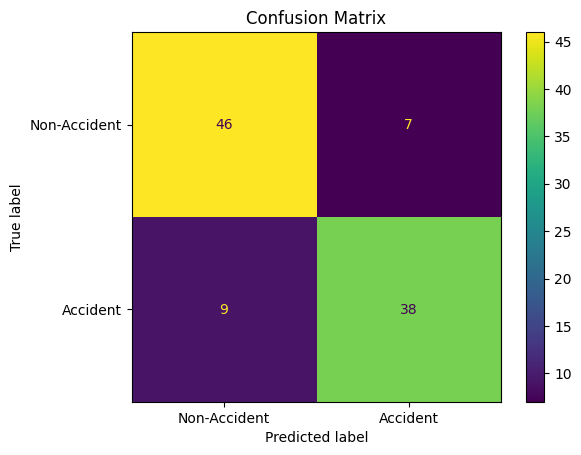


------------------------------------------------------------------------------------------



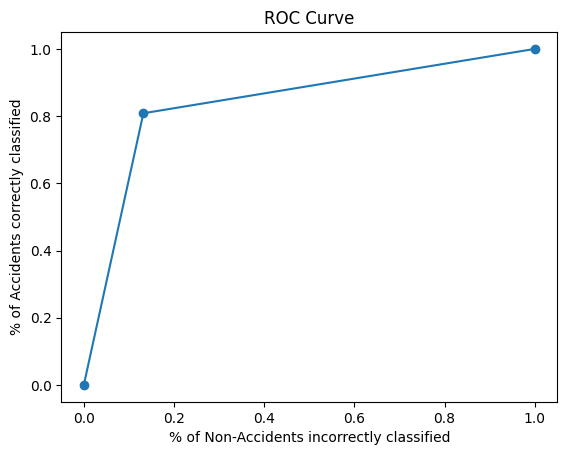


------------------------------------------------------------------------------------------

AUC score is: 0.84


In [41]:
clf.fit(X_train_gray_sc, y_train_final)
pred_gray_val = clf.predict(X_test_gray_sc)
calculate_metrics(pred_gray_val, y_test)

So, the best we could do using **Linear SVM** is a validation fbeta score (beta = 1.4) of 0.82, with the parameters:
- random_state = 5000
- class_weight= {0:1, 1:1.5}
- dual='auto',
- max_iter=10000
- C =  2.740867157543261
- intercept_scaling = 10.0
- loss= 'hinge'
- penalty = 'l2'
- tol= 1e-1